Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change'], dtype='object')
         Date     Price      Open      High       Low  Vol.  Change
0  11/18/2025  1,459.39  1,462.28  1,468.55  1,458.35   NaN  -0.20%
1  11/17/2025  1,462.28  1,448.21  1,463.15  1,448.21   NaN   0.95%
2  11/14/2025  1,448.53  1,468.69  1,474.75  1,447.50   NaN  -1.51%
3  11/13/2025  1,470.70  1,467.14  1,475.45  1,461.19   NaN   0.09%
4  11/12/2025  1,469.36  1,460.84  1,470.18  1,459.35   NaN   0.58%
            Date     Price      Open      High       Low  Vol.  Change
2605  11/24/2015  1,145.72  1,158.86  1,159.91  1,146.45   NaN  -1.05%
2606  11/23/2015  1,157.86  1,154.61  1,161.76  1,153.85   NaN   0.37%
2607  11/20/2015  1,153.62  1,155.86  1,160.53  1,150.36   NaN  -0.09%
2608  11/19/2015  1,154.66  1,166.39  1,167.82  1,155.36   NaN  -0.93%
2609  11/18/2015  1,165.45  1,169.67  1,175.51  1,166.21   NaN  -0.28%
        Date     Price      Open      High       Low
0 2015-11-18  1,165.45  1,169.6

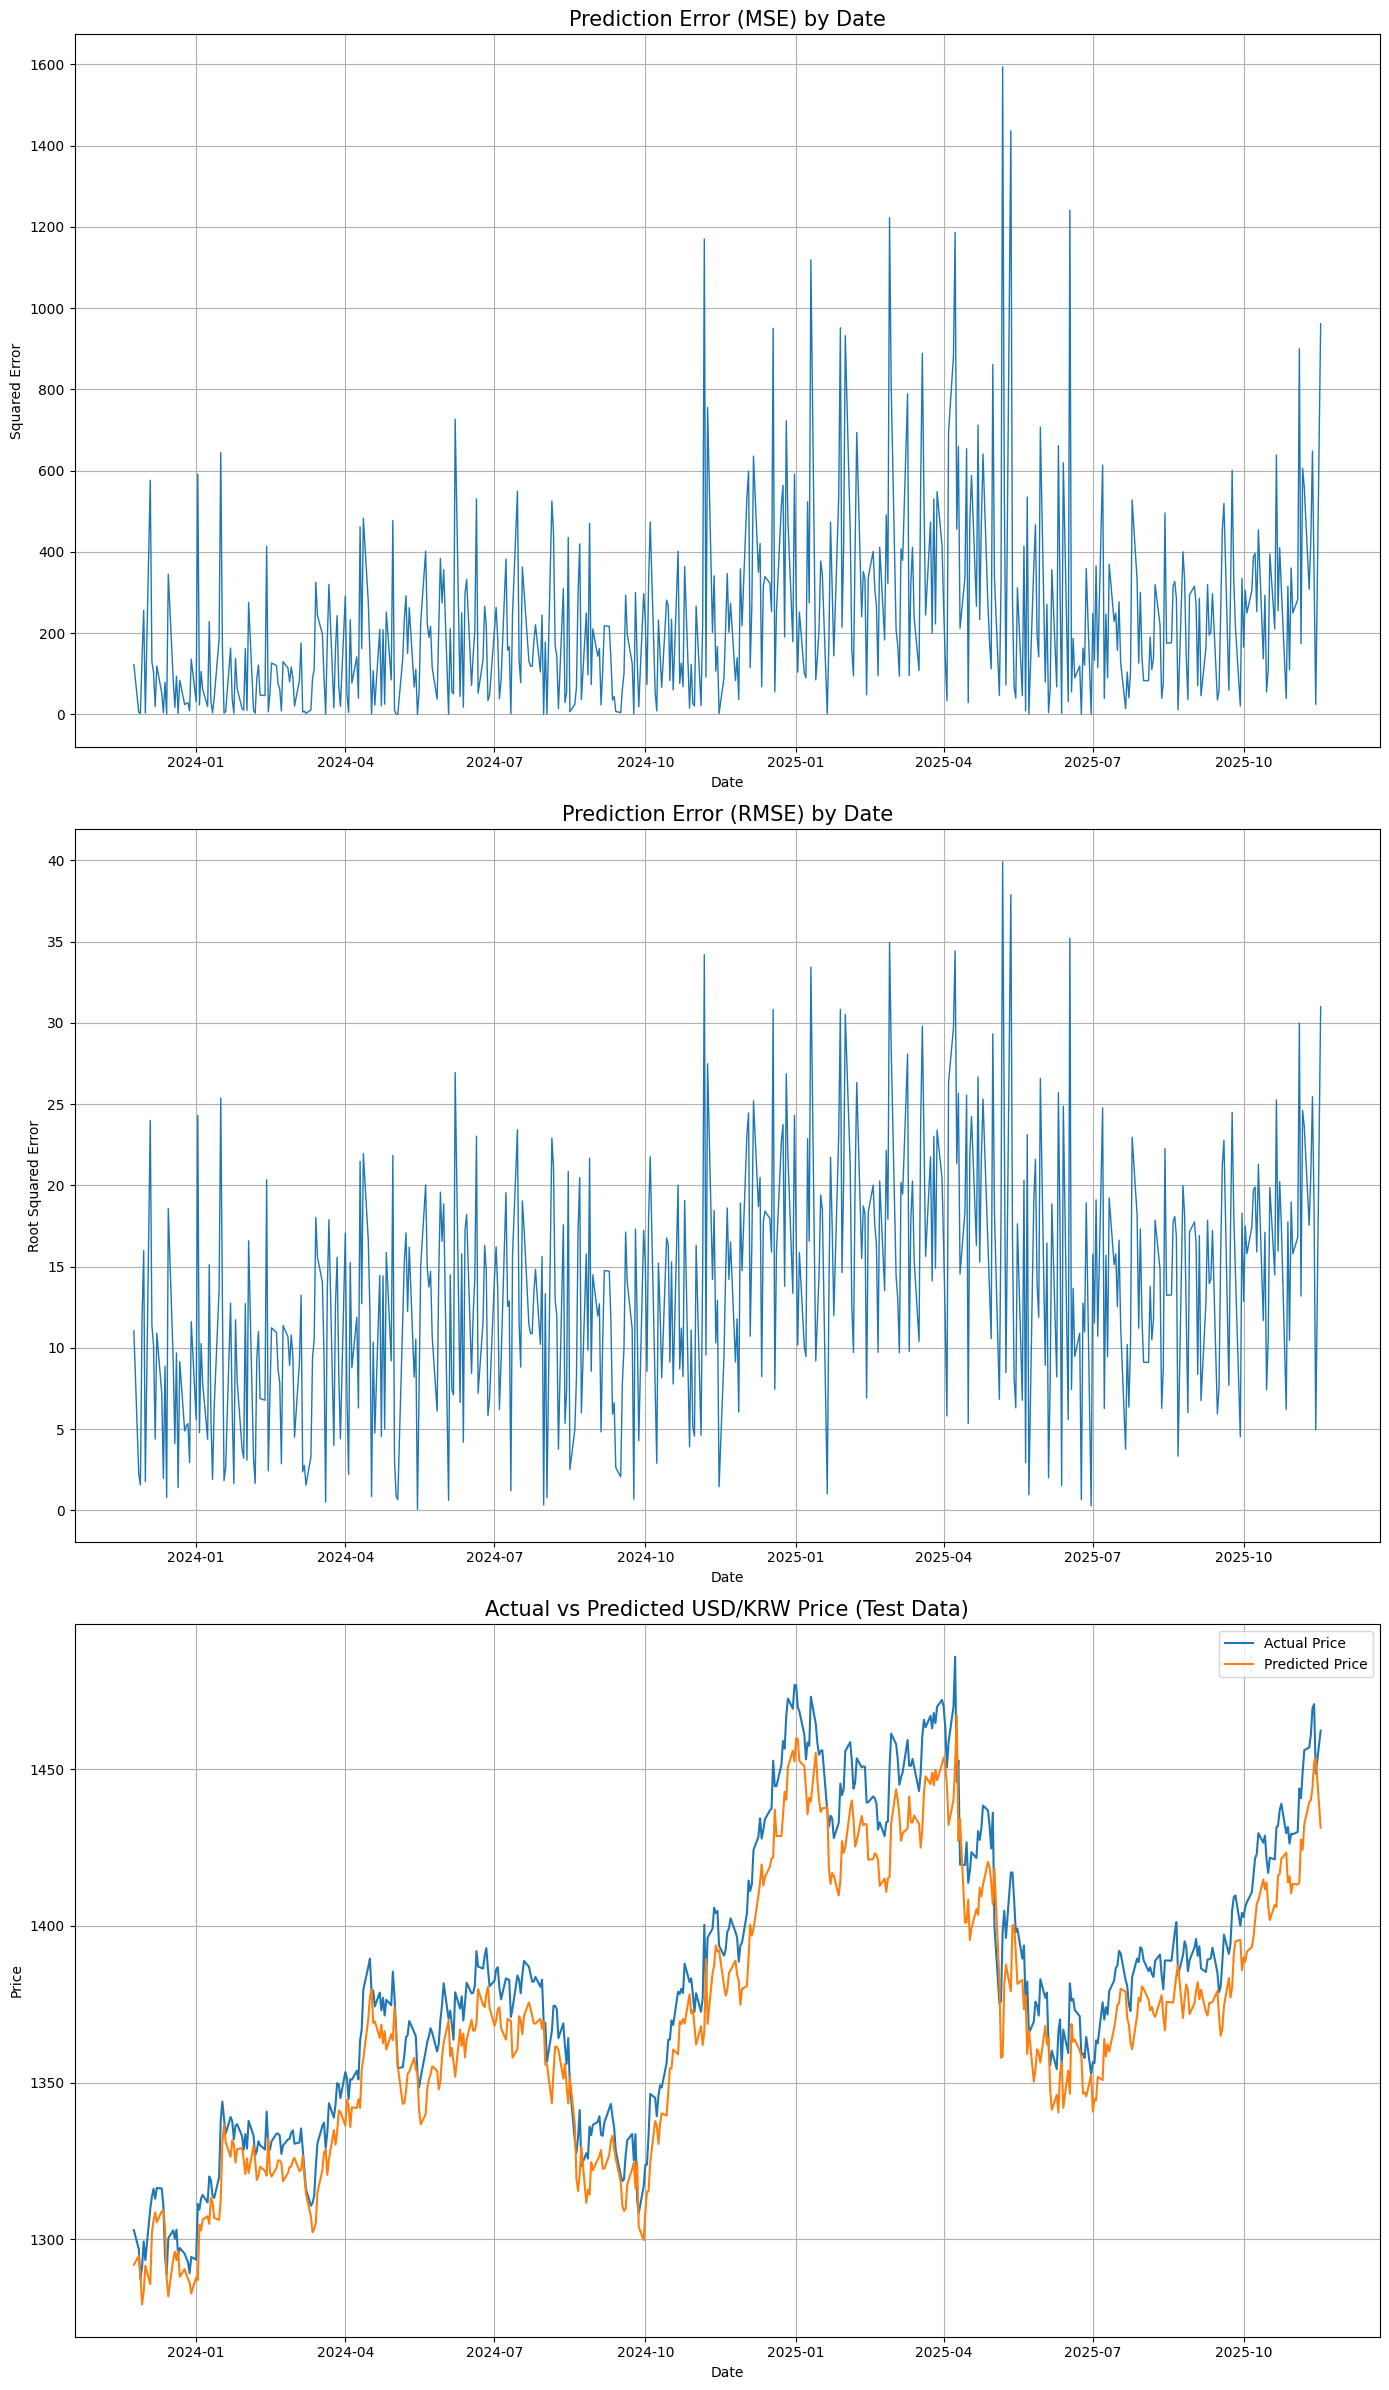

In [3]:
# ===============================
# USD/KRW Transformer (Δ 예측 버전: window_size=30, last-token pooling)

import pandas as pd
import numpy as np

# ===============================
# 0. 데이터 로드 & 기본 정리
# ===============================
df = pd.read_csv("exchange_data.csv")

print(df.columns)
print(df.head())
print(df.tail())

# 날짜 변환 & 정렬
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

data = df[["Date", "Price", "Open", "High", "Low"]].copy()
print(data.head())
print(data.tail())
print("data shape:", data.shape)

# ===============================
# 1. 전처리 & 스케일링
# ===============================
from sklearn.preprocessing import MinMaxScaler

feature_cols = ["Price", "Open", "High", "Low"]

# 쉼표 제거 + float 변환
for col in feature_cols:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False).astype(float)

# 원본 절대 Price
price = data["Price"].values.astype(float)        # (N,)

# (1) X(OHLC) 입력 스케일링
features = data[feature_cols].values             # (N, 4)
scaler_X = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)

# (2) y = Δ(다음날 가격 - 오늘 가격) 스케일링
delta = price[1:] - price[:-1]                  # (N-1,)
scaler_y = MinMaxScaler()
delta_scaled = scaler_y.fit_transform(delta.reshape(-1, 1))  # (N-1, 1)

# ===============================
# 2. windowing (다변량 X, 단일 Δ, last_price)
# ===============================
def create_windowed_dataset_multivariate(X_all, delta_all, price_all, window_size):
    X = []
    y = []
    last_prices = []  # 복원용: window 마지막 날의 실제 가격

    N = len(price_all)  # 날짜/price 개수
    # i: window 시작 인덱스
    for i in range(N - window_size - 1):
        # window: i ~ i+window_size-1
        X.append(X_all[i:i+window_size])              # (window_size, 4)

        # Δ는 "window 마지막 날 → 그 다음날" 변화량
        delta_idx = i + window_size - 1              # 마지막 날에 해당하는 Δ 인덱스
        y.append(delta_all[delta_idx, 0])            # Δ_scaled

        # window 마지막 날의 실제 가격 (tomorrow 직전 가격)
        last_prices.append(price_all[delta_idx])

    return np.array(X), np.array(y), np.array(last_prices)

window_size = 30  # 🔥 실험용 window 크기

X, y, last_prices = create_windowed_dataset_multivariate(
    features_scaled, delta_scaled, price, window_size
)

print("X:", X.shape)             # (N_samples, 30, 4)
print("y (delta):", y.shape)     # (N_samples,)
print("last_prices:", last_prices.shape)

# ===============================
# 3. train / val / test split
# ===============================
N_windows = len(X)
train_size = int(N_windows * 0.6)
val_size = int(N_windows * 0.2)

X_train = X[:train_size]
y_train = y[:train_size]
last_prices_train = last_prices[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
last_prices_val = last_prices[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]
last_prices_test = last_prices[train_size+val_size:]

import torch

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

print("X_train_t shape:", X_train_t.shape)
print("y_train_t shape:", y_train_t.shape)
print("X_val_t shape:", X_val_t.shape)
print("y_val_t shape:", y_val_t.shape)
print("X_test_t shape:", X_test_t.shape)
print("y_test_t shape:", y_test_t.shape)

# ===============================
# 4. DataLoader
# ===============================
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32

train_loader = DataLoader(TimeSeriesDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=False)

val_loader = DataLoader(TimeSeriesDataset(X_val_t, y_val_t),
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TimeSeriesDataset(X_test_t, y_test_t),
                         batch_size=batch_size, shuffle=False)

# ===============================
# 5. Transformer 모델 (B: last-token pooling 적용)
# ===============================
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        seq_len=60,
        feature_dim=4,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1
    ):
        super().__init__()

        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_embedding = nn.Embedding(seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc1 = nn.Linear(d_model, d_model)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(d_model, 1)

        self.seq_len = seq_len

    def forward(self, x):
        # x: (batch, seq_len, feature_dim)
        x = self.input_proj(x)  # (batch, seq_len, d_model)

        batch_size = x.size(0)
        device = x.device
        positions = torch.arange(self.seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        pos_embed = self.pos_embedding(positions)

        x = x + pos_embed
        x = self.encoder(x)  # (batch, seq_len, d_model)

        # 🔥 B: 마지막 시점 hidden state만 사용
        x_last = x[:, -1, :]  # (batch, d_model)

        h = self.fc1(x_last)
        h = self.act(h)
        out = self.fc2(h)     # (batch, 1)

        return out.squeeze(-1)  # (batch,)

model = TimeSeriesTransformer(
    seq_len=window_size,   # 30
    feature_dim=4,
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.3
)

dummy_input = torch.randn(32, window_size, 4)
print("dummy output shape:", model(dummy_input).shape)

# ===============================
# 6. 학습 루프
# ===============================
import torch.optim as optim
from tqdm import tqdm
import math

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

def evaluate_mse(loader, model, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            losses.append(loss.item())
    return sum(losses) / len(losses)

train_mse = evaluate_mse(train_loader, model, criterion)
val_mse = evaluate_mse(val_loader, model, criterion)
test_mse = evaluate_mse(test_loader, model, criterion)

print(f"Train MSE(Δ): {train_mse:.6f}, RMSE(Δ): {math.sqrt(train_mse):.6f}")
print(f"Val   MSE(Δ): {val_mse:.6f}, RMSE(Δ): {math.sqrt(val_mse):.6f}")
print(f"Test  MSE(Δ): {test_mse:.6f}, RMSE(Δ): {math.sqrt(test_mse):.6f}")

# ===============================
# 7. Δ 예측 → 실제 가격 복원 → 그래프
# ===============================
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)                    # (batch,)
        all_preds.append(preds.detach().cpu().numpy())
        all_trues.append(y_batch.detach().cpu().numpy())

delta_pred_scaled = np.concatenate(all_preds)   # (N_test,)
delta_true_scaled = np.concatenate(all_trues)   # (N_test,)

# Δ를 원 단위로 역변환
delta_pred_actual = scaler_y.inverse_transform(delta_pred_scaled.reshape(-1, 1)).ravel()
delta_true_actual = scaler_y.inverse_transform(delta_true_scaled.reshape(-1, 1)).ravel()

# 마지막 실제 가격에 Δ를 더해서 "내일 가격" 복원
y_pred_actual = last_prices_test + delta_pred_actual
y_true_actual = last_prices_test + delta_true_actual

# 날짜 인덱스: "내일" 날짜
test_start_in_X = train_size + val_size
N_test = len(y_test)

target_indices = np.arange(
    test_start_in_X + window_size,
    test_start_in_X + window_size + N_test
)
test_dates = data["Date"].iloc[target_indices].values

# 에러 계산
squared_error = (y_pred_actual - y_true_actual) ** 2
rmse_error = np.sqrt(squared_error)

results = pd.DataFrame({
    "Date": test_dates,
    "Actual": y_true_actual,
    "Predicted": y_pred_actual,
    "SquaredError": squared_error,
    "RMSE_Error": rmse_error,
})

print("=== std 비교 ===")
print("std of true  :", np.std(y_true_actual))
print("std of pred  :", np.std(y_pred_actual))
print("min/max true :", y_true_actual.min(), y_true_actual.max())
print("min/max pred :", y_pred_actual.min(), y_pred_actual.max())

# 11. 시각화
plt.figure(figsize=(14, 24))

# (1) MSE Plot
plt.subplot(3, 1, 1)
plt.plot(test_dates, squared_error, linewidth=1)
plt.title("Prediction Error (MSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Squared Error")
plt.grid(True)

# (2) RMSE Plot
plt.subplot(3, 1, 2)
plt.plot(test_dates, rmse_error, linewidth=1)
plt.title("Prediction Error (RMSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Root Squared Error")
plt.grid(True)

# (3) Actual vs Predicted Plot
plt.subplot(3, 1, 3)
plt.plot(test_dates, y_true_actual, label="Actual Price", linewidth=1.5)
plt.plot(test_dates, y_pred_actual, label="Predicted Price", linewidth=1.5)
plt.title("Actual vs Predicted USD/KRW Price (Test Data)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()